In [1]:
import pandas as pd
import numpy as np
import netCDF4 as nc

In [2]:
def get_spaced_point(coords):
    N = len(coords)
    good_points = np.array(list(range(N)))
    good_points = good_points.astype(float)
    min_spacing = 8000
    for i in range(N):
        if ~np.isnan(good_points[i]):
            #print(i)
            dist = np.sqrt(np.square(coords[:, 0] - coords[i, 0]) + np.square(coords[:, 1] - coords[i, 1]))
            idx = dist < min_spacing
            #print(dist)
            good_points[idx] = np.nan
            good_points[i] = i
            
    good = good_points[~np.isnan(good_points)]
    good = good.astype(int)
            
    return good

In [2]:
fname = "/Volumes/jilab/gom3_hourly/gom3_198405.nc"

In [3]:
d = nc.Dataset(fname)
d.variables

{'nprocs': <class 'netCDF4._netCDF4.Variable'>
 int32 nprocs()
     long_name: number of processors
 unlimited dimensions: 
 current shape = ()
 filling on, default _FillValue of -2147483647 used,
 'partition': <class 'netCDF4._netCDF4.Variable'>
 int32 partition(nele)
     long_name: partition
 unlimited dimensions: 
 current shape = (90415,)
 filling on, default _FillValue of -2147483647 used,
 'x': <class 'netCDF4._netCDF4.Variable'>
 float32 x(node)
     long_name: nodal x-coordinate
     units: meters
 unlimited dimensions: 
 current shape = (48451,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'y': <class 'netCDF4._netCDF4.Variable'>
 float32 y(node)
     long_name: nodal y-coordinate
     units: meters
 unlimited dimensions: 
 current shape = (48451,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'lon': <class 'netCDF4._netCDF4.Variable'>
 float32 lon(node)
     long_name: nodal longitude
     standard_name: longitude
     units: degrees_east

In [4]:
lon, lat = d['x'], d['y']
coords = np.hstack((np.array([lon]).transpose(), np.array([lat]).transpose()))
coords

array([[1694489.8 ,  413970.56],
       [1699879.8 ,  420500.3 ],
       [1705179.5 ,  414890.34],
       ...,
       [ 584451.9 , -128396.33],
       [ 584104.94, -127881.32],
       [ 584823.8 , -127965.56]], dtype=float32)

In [6]:
min(lon), max(lon)

(masked_array(data=410692.8,
              mask=False,
        fill_value=1e+20,
             dtype=float32),
 masked_array(data=1999315.8,
              mask=False,
        fill_value=1e+20,
             dtype=float32))

In [11]:
area1 = d['art1'][:]/1000/1000
area2 = d['art2'][:]/1000/1000

In [13]:
min(area1), max(area1), min(area2), max(area2)

(0.02261047, 1385.7443, 0.06781736, 4157.2373)

In [18]:
max(area1*3 - area2)

0.00592041

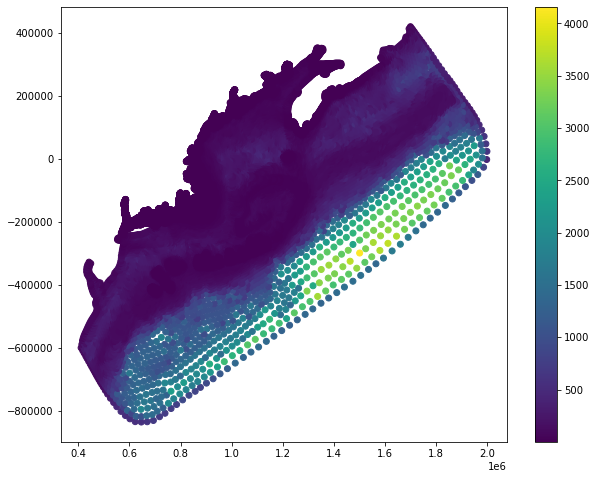

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
s = ax.scatter(coords[:, 0], coords[:, 1], c=area)
plt.colorbar(s)

In [9]:
temp_bot = d['temp'][0, -1, :]
temp_sur = d['temp'][0, 0, :]

In [10]:
temp_bot, temp_sur

(masked_array(data=[3.9754753, 4.1000733, 4.130077 , ..., 9.281097 ,
                    9.28139  , 9.281199 ],
              mask=False,
        fill_value=1e+20,
             dtype=float32),
 masked_array(data=[4.0540953, 3.9622228, 4.0533566, ..., 9.276658 ,
                    9.276618 , 9.276606 ],
              mask=False,
        fill_value=1e+20,
             dtype=float32))

In [18]:
good = get_spaced_point(coords)
good

array([    0,     1,     2, ..., 48407, 48427, 48440])

In [22]:
x, y, temp, salt, depth = d['x'], d['y'], d['temp'][0, 0, :].data, d['salinity'][0, 0, :].data, d['h']

In [31]:
depth

<class 'netCDF4._netCDF4.Variable'>
float32 h(node)
    long_name: Bathymetry
    standard_name: sea_floor_depth_below_geoid
    units: m
    positive: down
    grid: Bathymetry_Mesh
    coordinates: x y
    type: data
unlimited dimensions: 
current shape = (48451,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [3]:
years = range(2010, 2017)
months = range(1, 13)

for year in years:
    for m in months:
        mo = str(m).zfill(2)
        fname = "environmental_data_{}{}.csv".format(year, mo)
        save_path = "../auxdata/environmental-data_new/{}".format(fname)
        
        fpath = "/Volumes/jilab/gom3_hourly/gom3_{}{}.nc".format(year, mo)
        
        d = nc.Dataset(fpath)
        
        x, y, temp, salt, depth = d['x'], d['y'], d['temp'][0, 0, :].data, d['salinity'][0, 0, :].data, d['h']
        
        
        
        coords = np.hstack((np.array([x]).transpose(), np.array([y]).transpose()))
        
        #print(coords)
        good = get_spaced_point(coords)
        
        x = x[good]
        y = y[good]
        temp = temp[good]
        salt = salt[good]
        depth = depth[good]
        
        out = np.hstack(
                        (np.array([x]).transpose(), 
                         np.array([y]).transpose(), 
                         np.array([temp]).transpose(),
                         np.array([salt]).transpose(),
                         np.array([depth]).transpose()
                        )
                       )
        
        d.close()
        
        np.savetxt(save_path, out, delimiter=",")

In [66]:
d = np.loadtxt("../auxdata/environmental-data_new/environmental_data_198001.csv", delimiter=",")
d

array([[ 1.69448975e+06,  4.13970562e+05,  4.05409527e+00,
         3.27348595e+01,  7.42789984e+00],
       [ 1.69987975e+06,  4.20500312e+05,  3.96222281e+00,
         3.27421074e+01,  8.64500046e+00],
       [ 1.70991000e+06,  4.09690188e+05,  4.08169079e+00,
         3.25175247e+01,  5.72249985e+00],
       ...,
       [ 5.81100188e+05, -1.46599391e+05,  9.32878399e+00,
         2.05566044e-33,  3.00000000e+00],
       [ 5.81379062e+05, -1.38324328e+05,  9.26512814e+00,
         1.45396088e-33,  3.00000000e+00],
       [ 5.83658188e+05, -1.30443648e+05,  9.27881527e+00,
         2.58338967e-34,  3.00000000e+00]])

In [17]:
import matplotlib.pyplot as plt

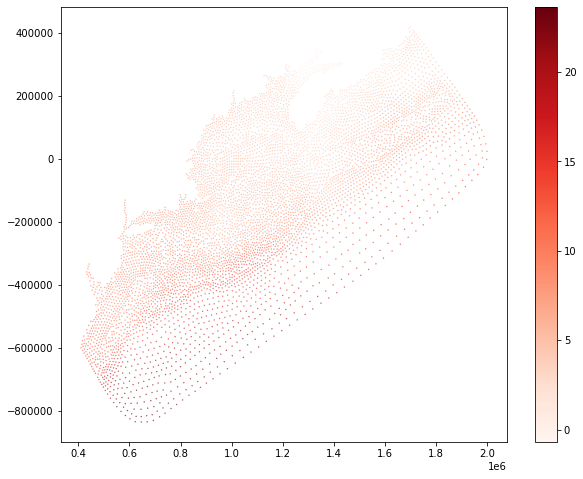

In [69]:
fig, ax = plt.subplots(figsize=(10, 8))
s = ax.scatter(d[:, 0], d[:, 1], c=d[:, 2], s=0.1, cmap="Reds")
plt.colorbar(s)

In [20]:
years = range(1978, 2017)
months = range(1, 13)

for year in years:
    print(year)
    for m in months:
        print(m)
        mo = str(m).zfill(2)
        fname = "environmental_data_{}{}.csv".format(year, mo)
        save_path = "../auxdata/environmental-data/{}".format(fname)
        
        fpath = "/Volumes/jilab/gom3_hourly/gom3_{}{}.nc".format(year, mo)
        
        d = nc.Dataset(fpath)
        
        x, y = d['x'], d['y'] 
        temp_bot, temp_surf = d['temp'][0, -1, :].data, d['temp'][0, 0, :].data
        salt_bot, salt_surf = d['salinity'][0, -1, :].data, d['salinity'][0, 0, :].data
        depth = d['h']
        area1 = d['art1']
    
        
        out = np.hstack(
                        (np.array([x]).transpose(), 
                         np.array([y]).transpose(), 
                         np.array([temp_bot]).transpose(),
                         np.array([temp_surf]).transpose(),
                         np.array([salt_bot]).transpose(),
                         np.array([salt_surf]).transpose(),
                         np.array([depth]).transpose(),
                         np.array([area1]).transpose()
                        )
                       )
        
        d.close()
        
        np.savetxt(save_path, out, delimiter=",")

1978
1
2
3
4
5
6
7
8
9
10
11
12
1979
1
2
3
4
5
6
7
8
9
10
11
12
1980
1
2
3
4
5
6
7
8
9
10
11
12
1981
1
2
3
4
5
6
7
8
9
10
11
12
1982
1
2
3
4
5
6
7
8
9
10
11
12
1983
1
2
3
4
5
6
7
8
9
10
11
12
1984
1
2
3
4
5
6
7
8
9
10
11
12
1985
1
2
3
4
5
6
7
8
9
10
11
12
1986
1
2
3
4
5
6
7
8
9
10
11
12
1987
1
2
3
4
5
6
7
8
9
10
11
12
1988
1
2
3
4
5
6
7
8
9
10
11
12
1989
1
2
3
4
5
6
7
8
9
10
11
12
1990
1
2
3
4
5
6
7
8
9
10
11
12
1991
1
2
3
4
5
6
7
8
9
10
11
12
1992
1
2
3
4
5
6
7
8
9
10
11
12
1993
1
2
3
4
5
6
7
8
9
10
11
12
1994
1
2
3
4
5
6
7
8
9
10
11
12
1995
1
2
3
4
5
6
7
8
9
10
11
12
1996
1
2
3
4
5
6
7
8
9
10
11
12
1997
1
2
3
4
5
6
7
8
9
10
11
12
1998
1
2
3
4
5
6
7
8
9
10
11
12
1999
1
2
3
4
5
6
7
8
9
10
11
12
2000
1
2
3
4
5
6
7
8
9
10
11
12
2001
1
2
3
4
5
6
7
8
9
10
11
12
2002
1
2
3
4
5
6
7
8
9
10
11
12
2003
1
2
3
4
5
6
7
8
9
10
11
12
2004
1
2
3
4
5
6
7
8
9
10
11
12
2005
1
2
3
4
5
6
7
8
9
10
11
12
2006
1
2
3
4
5
6
7
8
9
10
11
12
2007
1
2
3
4
5
6
7
8
9
10
11
12
2008
1
2
3
4
5
6
7
8
9
10
11
12
2009
1
2